In [1]:
# Libs
#torch"
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import logging
import pandas as pd
from collections import OrderedDict
import pickle
import numpy as np
import seaborn as sns
import datetime
import os
import random
import glob
import matplotlib.pyplot as plt
from functools import reduce
# Own Modules
from source_torch.mlca.mlca_setup import set_value_model_parameters
from source_torch.mlca.mlca import mlca_mechanism
from source_torch.util import save_result,load_result

MLCA NN Class imported
MLCA NN_MIP Class imported
WDP Class imported
MLCA_Economies imported
MLCA function imported


In [3]:
# log debug to console
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s:               %(message)s', datefmt='%H:%M:%S')
device0='cuda'
torch.cuda.is_available()
dirname = './experiments/MLCA/Torch/results'

In [79]:
#Preparations
# model_name_1 = dirname + '/GSVM_unif'#LSVM MRVM GSVM
# model_name_2 = dirname + '/LSVM_unif'
# model_name_3 = dirname + '/MRVM_unif'
# model_name_4 = dirname + '/GSVM_gali'
# model_name_5 = dirname + '/LSVM_gali'
# model_name_6 = dirname + '/MRVM_gali'
#add all folders from dirname to a list
models = []

for root, dirs, files in os.walk(dirname):
    if dirs:
        for fold in dirs:
            models.append(dirname + '/' + fold)

print(models)
def find_files(directory):
    results = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            res = load_result((os.path.join(root, file)))
            results.append(res)
            print(res['SEED TRUE VALUES']['Seed'])
    return results


results = {}
for path in models:
    res = find_files(path)
    if res:
        results[path] = res

['./experiments/MLCA/Torch/results/GSVM_unif', './experiments/MLCA/Torch/results/MRVM_unif', './experiments/MLCA/Torch/results/LSVM_gali', './experiments/MLCA/Torch/results/LSVM_unif', './experiments/MLCA/Torch/results/GSVM_gali']
./experiments/MLCA/Torch/results/GSVM_unif/results_2 is loaded 
2
./experiments/MLCA/Torch/results/GSVM_unif/7_19_14_34_5 is loaded 
5
./experiments/MLCA/Torch/results/GSVM_unif/results_1 is loaded 
1
./experiments/MLCA/Torch/results/GSVM_unif/results_4 is loaded 
4
./experiments/MLCA/Torch/results/GSVM_unif/results_0 is loaded 
0
./experiments/MLCA/Torch/results/GSVM_unif/results_3 is loaded 
3
./experiments/MLCA/Torch/results/MRVM_unif/results_1 is loaded 
1
./experiments/MLCA/Torch/results/MRVM_unif/results_0 is loaded 
0
./experiments/MLCA/Torch/results/LSVM_gali/results_1 is loaded 
1
./experiments/MLCA/Torch/results/LSVM_gali/results_0 is loaded 
0
./experiments/MLCA/Torch/results/LSVM_unif/results_5 is loaded 
5
./experiments/MLCA/Torch/results/LSVM_un

In [80]:
results.keys()

dict_keys(['./experiments/MLCA/Torch/results/GSVM_unif', './experiments/MLCA/Torch/results/MRVM_unif', './experiments/MLCA/Torch/results/LSVM_gali', './experiments/MLCA/Torch/results/LSVM_unif', './experiments/MLCA/Torch/results/GSVM_gali'])

In [81]:
for i in results.keys():
    print(i + ': ')
    #average MLCA Efficiency of all runs
    print('Average MLCA Efficiency: ' + str(np.mean([results[i][j]['MLCA Efficiency'] for j in range(len(results[i]))])))
    #average number of iterations of all runs
    print('Average Number of Iterations: ' + str(np.mean([len(results[i][j]['Statistics']['Efficiency per Iteration']) for j in range(len(results[i]))])))
    #Total time elapsed of all runs
    print('Total Time Elapsed for an instance: ' + str([results[i][j]['Statistics']['Total Time Elapsed'] for j in range(len(results[i]))]))

./experiments/MLCA/Torch/results/GSVM_unif: 
Average MLCA Efficiency: 0.9630226058416573
Average Number of Iterations: 3.0
Total Time Elapsed for an instance: ['0d 0h:29m:28s', '0d 0h:27m:45s', '0d 0h:28m:27s', '0d 0h:27m:5s', '0d 1h:2m:30s', '0d 0h:24m:14s']
./experiments/MLCA/Torch/results/MRVM_unif: 
Average MLCA Efficiency: 0.9220221370548547
Average Number of Iterations: 7.0
Total Time Elapsed for an instance: ['0d 4h:25m:44s', '0d 6h:53m:10s']
./experiments/MLCA/Torch/results/LSVM_gali: 
Average MLCA Efficiency: 0.9521407343129331
Average Number of Iterations: 2.0
Total Time Elapsed for an instance: ['0d 0h:24m:0s', '0d 0h:19m:42s']
./experiments/MLCA/Torch/results/LSVM_unif: 
Average MLCA Efficiency: 0.8591625963905684
Average Number of Iterations: 2.0
Total Time Elapsed for an instance: ['0d 0h:28m:14s', '0d 0h:23m:9s', '0d 0h:20m:21s', '0d 1h:14m:18s']
./experiments/MLCA/Torch/results/GSVM_gali: 
Average MLCA Efficiency: 0.9803668763924998
Average Number of Iterations: 3.0
Tot

In [82]:
#function to efficiency for different models
def plot_efficiency(results):
    types = results.keys()
    df = pd.DataFrame(columns=['Efficiency', 'Type'])
    for i in results.keys():
        # get mean efficiency
        eff = np.mean([results[i][j]['MLCA Efficiency'] for j in range(len(results[i]))])
        df = df.append({'Efficiency': eff, 'Type': i}, ignore_index=True)
    
    sns.set(style="whitegrid")
    g = sns.catplot(
    data=df, kind="bar",
    x="Type", y="Efficiency", palette="dark", alpha=.6, height=6
    )
    # hue="something additional on the right"
    #errorbar="Standard Deviation"
    #g.despine(left=True)
    g.set_axis_labels("", "Efficiency")

def plot_efficiency_per_round(results):
    types = results.keys()
    #get mean efficiency per round
     
    df = pd.DataFrame(columns=['Iteration', 'Efficiency', 'Type'])
    for i in results.keys():
        for j in range(len(results[i]['Statistics']['Efficiency per Iteration'])):
            eff = np.mean([results[i][k]['Statistics']['Efficiency per Iteration'][j] for k in range(len(results[i]))])
            df = df.append({'Iteration': j, 'Efficiency': eff, 'Type': i}, ignore_index=True)
    
    sns.set_theme(style="darkgrid")
    sns.lineplot(x="Iteration", y="Efficiency",
             data=df, hue = 'Type')
    # Get the current axes object
    ax = plt.gca()

    # Set custom steps for the x-axis ticks
    custom_ticks = np.arange(0, np.max(df['Iteration'])+1, 1)  # Custom steps: start=0, stop=10, step=2
    ax.set_xticks(custom_ticks)

In [84]:
#plot_efficiency_per_round(results)
#plot_efficiency(results)

TypeError: list indices must be integers or slices, not str

In [30]:
results[2]['Statistics']['Efficiency per Iteration']

OrderedDict([(0, 0.5083803905189288),
             (1, 0.8721127072078818),
             (2, 0.902746982296867),
             (3, 0.9128866737766014),
             (4, 0.9128866737766025),
             (5, 0.9128866737766014),
             (6, 0.9357784382230352),
             (7, 0.9357784382230294),
             (8, 0.9357784382230316),
             (9, 0.9439172925977332)])

In [14]:
def _get_file_names(dir_file,Domain,Qinit,Qmax,Seed):
    Domain=Domain
    Qinit= Qinit
    Qmax= Qmax
    Seed = Seed
    my_dict={}
    
    for i in Domain:
        for l in Qinit:
            for k in Qmax:
                for j in Seed:
                    key_name=i+'_'+str(l)+'_'+str(k)+'_'+str(j)
                    instance = dir_file+i+'_'+str(l)+'_'+str(k)+'_'+str(j)+'_'+'*'
                    my_dict[key_name]=glob.glob(instance)

    my_dict = dict( [(k,v) for k,v in my_dict.items() if len(v)>0])
    return(my_dict)

def _retrieve_data(my_dict):
    mydict_data={}
    for key, value in my_dict.items():
        data=[]
        for i in my_dict[key]:
            tmp=load_result(i)
            data.append(tmp['result'])
        mydict_data[key] = pd.DataFrame.from_records(data)
    return(mydict_data)

def NN_Bidder_df(dict_nn,summary):
    seeds = list(dict_nn.keys())
    bidders = list(dict_nn[seeds[0]]['Main Economy'].keys())
    rounds= list(np.arange(0,len(dict_nn[seeds[0]]['Main Economy'][bidders[0]]),1))

    main_dict = {}
    if summary[0] =='Full':
        for seed in seeds:
            main_dict[seed]={}
            for bidder in bidders:
                main_dict[seed][bidder]={}
                for rond in rounds:
                    main_dict[seed][bidder][rond]=[]
                    for marginal,values in dict_nn[seed].items() :
                        try:
                            main_dict[seed][bidder][rond].append(dict_nn[seed][marginal][bidder][rond][2])
                        except:
                            pass
        return(pd.DataFrame.from_dict(main_dict))

                    
    elif summary[0]=='Compact':
        for bidder in bidders:
            main_dict[bidder]={}
            for rond in rounds:
                main_dict[bidder][rond]=[]
                for seed in seeds:
                    for marginal,values in dict_nn[seed].items():
                        try:
                            main_dict[bidder][rond].append(dict_nn[seed][marginal][bidder][rond][2])
                        except:
                            pass
    
        if summary[1]=='Average':
            summary_dict= pd.DataFrame({'Round':[],'Mean':[],'Std':[],'Type':[]})
            for bidder in bidders:
                for rond in rounds:
                    mean=np.array(main_dict[bidder][rond]).mean()
                    std=np.array(main_dict[bidder][rond]).std()
                    new_row= {'Round':rond,'Mean':mean,'Std':std,'Type':bidder}
                    summary_dict = summary_dict.append(new_row, ignore_index=True)
                    
            return(summary_dict)

        elif summary[1]=='Particular':
            summary_dict= pd.DataFrame({'Round':[],'Error':[],'Type':[]})
            for bidder in bidders:
                for rond in rounds:
                    tmp = main_dict[bidder][rond]
                    for i in range(len(tmp)):
                        new_row= {'Round':rond,'Error':tmp[i],'Type':bidder}
                        summary_dict = summary_dict.append(new_row, ignore_index=True)
                        
            return(summary_dict)                        
        elif summary[1]=='None':
                  
            return(pd.DataFrame.from_dict(main_dict))
        
def Eff_round(raw_dict,setting):
    seeds = list(raw_dict.keys())
    rounds= list(raw_dict[seeds[0]].keys())
    tpe= setting
    df= pd.DataFrame({'Round':[],'Efficiency':[],'Type':setting})
    for seed in seeds:
        for rond in rounds:
            new_row= {'Round':rond,'Efficiency':raw_dict[seed][rond],'Type':setting}
            df = df.append(new_row, ignore_index=True)    
    
    return(df)


def get_results(dir_file,Domain,Qinit,Qmax,Seed):
    Domain=Domain
    Qinit= Qinit
    Qmax= Qmax
    Seed = Seed
    my_dict={}
    
    my_dict=_get_file_names(dir_file,Domain,Qinit,Qmax,Seed)
    mydict_data=_retrieve_data(my_dict)
    
    return(mydict_data)

def get_summary(input_dict,criteria):
    my_dict={}
    if criteria=='Efficiency':
    
        for keys in input_dict.keys():
            my_dict[keys]=input_dict['Statistics'][0]['Efficiency per Iteration']
            
        return(pd.DataFrame.from_records(my_dict))
            
    elif criteria=='NN Losses':
            
        for keys in input_dict.keys():
            my_dict[keys]=input_dict[keys]['Statistics'][0]['NN Losses']
            
        return(my_dict)

        
    elif criteria=='Total Time':
            
        for keys in input_dict.keys():
            my_dict[keys]=[input_dict['Statistics'][0]['Total Time Elapsed']]
        
        return(pd.DataFrame.from_dict(my_dict))


In [15]:
#tensor-pytorch
Domain = ['GSVM']
Qinit= [30]
Qmax= [100]
Seed = np.arange(10,500,10)

dir_file_1 = './experiments/alper/Alloc/mip_alloc/gsvm_mip/'
dir_file_2 = './experiments/MLCA/Alloc/pytorch_alloc/GSVM_final/'
# dir_file_3 = './experiments/MLCA/Alloc/pytorch_alloc/sample_numbers/sample-100/'
# dir_file_4 = './experiments/MLCA/Alloc/pytorch_alloc/sample_numbers/sample-500/'
# dir_file_5 = './experiments/MLCA/Alloc/pytorch_alloc/sample_numbers/sample-1k/'


#file_1 = get_results(result_file_dir,['GSVM'],Qinit,Qmax,Seed)
#print(file_1)
#file_2 = get_results(dir_file_2,['GSVM'],Qinit,Qmax,Seed)
# file_3 = get_results(dir_file_3,['GSVM'],Qinit,Qmax,Seed)
# file_4 = get_results(dir_file_4,['GSVM'],Qinit,Qmax,Seed)
# file_5 = get_results(dir_file_5,['GSVM'],Qinit,Qmax,Seed)


df_file_1 = get_summary(result_file,criteria='Efficiency')
print(df_file_1)
#df_file_2=get_summary(file_2,criteria='Efficiency')
# df_file_3=get_summary(file_3,criteria='Efficiency')
# df_file_4=get_summary(file_4,criteria='Efficiency')
# df_file_5=get_summary(file_5,criteria='Efficiency')

eff_file_1 = Eff_round(df_file_1,'GSVM DL-ICA')
#eff_file_2 = Eff_round(df_file_2,'GSVM RL-ICA')
# eff_file_3 = Eff_round(df_file_3,'Sample Number 100')
# eff_file_4 = Eff_round(df_file_4,'Sample Number 500')
# eff_file_5 = Eff_round(df_file_5,'Sample Number 1000')

combined = eff_file_1.merge(eff_file_2,how='outer')
# combined = combined.merge(eff_file_3,how='outer')
# combined = combined.merge(eff_file_4,how='outer')
# combined = combined.merge(eff_file_5,how='outer')

KeyError: 0

In [5]:
sns.catplot(x="Efficiency", y="Round", row="Type",
                kind="box", orient="h", height=2, aspect=4,
                data=combined)

sns.lineplot(
    data=combined,
    x="Round", y="Efficiency", hue="Type", err_style='bars',
    markers=True, dashes=True
)

NameError: name 'combined' is not defined

In [41]:
df_file_1 = get_summary(result_file,criteria='Total Time')
df_file_2 = get_summary(result_file,criteria='Total Time')


runtime_file_1=pd.to_timedelta(df_file_1.transpose()[0])
runtime_file_2=pd.to_timedelta(df_file_2.transpose()[0])



df_run_file_1 =pd.DataFrame({
    'Run Time(m)' : (runtime_file_1.astype('timedelta64[m]')).array,
    'Type' : 'DL-ICA'})
df_run_file_2 =pd.DataFrame({
    'Run Time(m)' : (runtime_file_2.astype('timedelta64[m]')).array,
    'Type' :'RL-ICA'})


frames = [df_run_file_1,df_run_file_2]

run_compact = pd.concat(frames)

KeyError: 'Statistics'

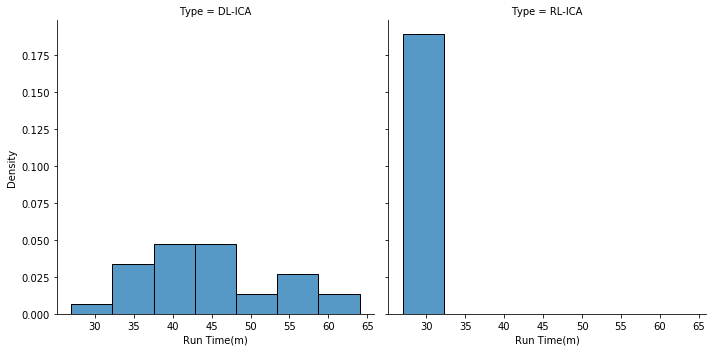

In [40]:
h=sns.displot(data=run_compact, x="Run Time(m)", col="Type", kde=False ,stat="density",common_norm=False)